In [2]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle , resample

In [98]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        # 建立输入节点与输出节点之间的连接
        for n in self.inputs:
            n.outputs.append(self)

        self.value = None

        self.gradients = {}
        

    def forward(self):
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented

In [99]:
# 输入节点类
class Input(Node):
    def __init__(self):
        Node.__init__(self)

    def forward(self, value=None):
        # 如果有输入值，则输入节点接收该值作为它自身的属性
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {self:0} 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

In [100]:
class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)

    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))

In [101]:
# 隐藏层线性组合类
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

In [102]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  

            self.gradients[self.inputs[0]] = grad_cost * self.partial

In [103]:
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

In [104]:
def forward_and_backward(outputnode, graph):
   
    for n in graph:
        n.forward()

    for n in  graph[::-1]:
        n.backward()

In [105]:
# 拓扑排序
def topological_sort(feed_dict):

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]


        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)

            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [106]:
def sgd_update(trainables, learning_rate=1e-2):

    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [16]:
data = load_boston()

In [17]:
X_ , y_ = data['data'],data['target']

In [109]:
print(X_.shape)
print(y_.shape)

(506, 13)
(506,)


In [110]:
losses = []

In [18]:
X_ = (X_ - np.mean(X_ , axis = 0)) / np.std(X_ , axis = 0)

In [112]:
# 接下来需要对神经网络的参数进行初始化 神经网络的参数初始化一般不为0
# 因为当参数初始化为0时会使得L1层隐藏单元完全对称也就是都是相同地  这样是没有意义地
# 故神经网络在参数初始化时一般随机选择一组具有高斯正态分布的数据
n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features,n_hidden)  # (13,10)
b1_ = np.random.randn(n_hidden)             # (10,)
W2_ = np.random.randn(n_hidden,1)           # (10,1)
b2_ = np.zeros(1)                           # (1,)

In [113]:
# 实例化输入节点作为Input类的对象
X  , y  = Input() , Input()
W1 , b1 = Input() , Input()
W2 , b2 = Input() , Input()

In [114]:
l1 = Linear(X, W1, b1) # 实例化Linear类并传入X,W1,b1三个对象 
s1 = Sigmoid(l1) 
l2 = Linear(s1,W2,b2)
cost = MSE(y, l2)

In [115]:
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

In [116]:
print(X.__dict__)
print(y.__dict__)
print(W1.__dict__)
print(b1.__dict__)
print(W2.__dict__)
print(b2.__dict__)

{'inputs': [], 'outputs': [<__main__.Linear object at 0x1a3d455898>], 'value': None, 'gradients': {}}
{'inputs': [], 'outputs': [<__main__.MSE object at 0x1a3d455908>], 'value': None, 'gradients': {}}
{'inputs': [], 'outputs': [<__main__.Linear object at 0x1a3d455898>], 'value': None, 'gradients': {}}
{'inputs': [], 'outputs': [<__main__.Linear object at 0x1a3d455898>], 'value': None, 'gradients': {}}
{'inputs': [], 'outputs': [<__main__.Linear object at 0x1a3d4555f8>], 'value': None, 'gradients': {}}
{'inputs': [], 'outputs': [<__main__.Linear object at 0x1a3d4555f8>], 'value': None, 'gradients': {}}


In [117]:
epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

In [118]:
print(steps_per_epoch)

31


In [119]:
graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

In [120]:
print("Total number of examples = {}".format(m))

Total number of examples = 506


In [121]:
print(graph)

[<__main__.Input object at 0x1a3d3df828>, <__main__.Input object at 0x1a3d450a58>, <__main__.Input object at 0x1a3d3df860>, <__main__.Input object at 0x1a3d3df278>, <__main__.Input object at 0x1a3d3ed898>, <__main__.Input object at 0x1a3d450898>, <__main__.Linear object at 0x1a3d455898>, <__main__.Sigmoid object at 0x1a3d455780>, <__main__.Linear object at 0x1a3d4555f8>, <__main__.MSE object at 0x1a3d455908>]


In [122]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [123]:
# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 0.01
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, Loss: 146.389
Epoch: 101, Loss: 5.867
Epoch: 201, Loss: 5.394
Epoch: 301, Loss: 3.376
Epoch: 401, Loss: 3.257
Epoch: 501, Loss: 3.464
Epoch: 601, Loss: 3.717
Epoch: 701, Loss: 3.004
Epoch: 801, Loss: 3.244
Epoch: 901, Loss: 3.274
Epoch: 1001, Loss: 3.432
Epoch: 1101, Loss: 3.203
Epoch: 1201, Loss: 2.895
Epoch: 1301, Loss: 3.258
Epoch: 1401, Loss: 2.802
Epoch: 1501, Loss: 3.314
Epoch: 1601, Loss: 3.154
Epoch: 1701, Loss: 2.945
Epoch: 1801, Loss: 3.167
Epoch: 1901, Loss: 2.818
Epoch: 2001, Loss: 2.670
Epoch: 2101, Loss: 2.507
Epoch: 2201, Loss: 2.563
Epoch: 2301, Loss: 2.390
Epoch: 2401, Loss: 2.482
Epoch: 2501, Loss: 2.634
Epoch: 2601, Loss: 2.793
Epoch: 2701, Loss: 2.711
Epoch: 2801, Loss: 2.481
Epoch: 2901, Loss: 2.732
Epoch: 3001, Loss: 2.963
Epoch: 3101, Loss: 2.519
Epoch: 3201, Loss: 2.443
Epoch: 3301, Loss: 2.491
Epoch: 3401, Loss: 2.622
Epoch: 3501, Loss: 2.628
Epoch: 3601, Loss: 2.453
Epoch: 3701, Loss: 2.921
Epoch: 3801, Loss: 2.703
Epoch: 3901, Loss: 2.912
Epoch: 400

In [125]:
import matplotlib.pyplot as plt

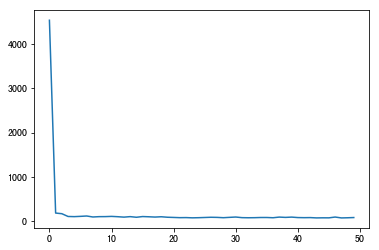

In [126]:
plt.plot(range(len(losses)),losses)

In [7]:
import keras

Using TensorFlow backend.


In [8]:
from keras.layers import Dense
from keras.models import Sequential

In [11]:
model = Sequential()

model.add(Dense(units=64,activation='sigmoid',input_dim=13))
model.add(Dense(units=30,activation='sigmoid',input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [ ]:
model.fit(X_, y_, epochs=2000, batch_size=32)

Epoch 1/2000
506/506 [==============================] - 0s 360us/step - loss: 156.9517 - mse: 156.9517
Epoch 2/2000
506/506 [==============================] - 0s 138us/step - loss: 68.5101 - mse: 68.5101
Epoch 3/2000
506/506 [==============================] - 0s 104us/step - loss: 49.8530 - mse: 49.8530
Epoch 4/2000
506/506 [==============================] - 0s 79us/step - loss: 37.7258 - mse: 37.7258
Epoch 5/2000
506/506 [==============================] - 0s 72us/step - loss: 30.7509 - mse: 30.7509
Epoch 6/2000
506/506 [==============================] - 0s 167us/step - loss: 26.1035 - mse: 26.1035
